In [16]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers,Model
from tensorflow.keras import datasets
from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from numpy import cov, trace, iscomplexobj,asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from skimage.transform import resize

In [17]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [18]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [19]:
latent_dim = 1024
image_shape = x_train[0].shape
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [20]:
class VAE(keras.Model):
    def __init__(self,latent_dim,image_shape,beta):
        super(VAE,self).__init__()

        self.latent_dim=latent_dim
        self.image_shape=image_shape
        self.beta=beta

        self.encoder=tf.keras.Sequential([
            layers.Input(shape=image_shape,name="Encoder_Input_layer"),

            layers.Conv2D(32,3,strides=2,activation="relu",padding='same',name="Encoder_Conv2D_2"),
            layers.Conv2D(64,3,strides=2,activation="relu",padding='same',name="Encoder_Conv2D_4"),
            layers.Conv2D(128,3,strides=2,activation="relu",padding='same',name="Encoder_Conv2D_6"),
            layers.Flatten(name="Encoder_Flatten"),
        ])

        self.z_mean=layers.Dense(latent_dim,name="z_mean")
        self.z_log_var=layers.Dense(latent_dim,name="z_log_var")

        self.decoder=tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(8*8*64,activation='relu'),
            layers.Reshape((8,8,64)),
            layers.Conv2DTranspose(64,kernel_size=3,strides=2,padding='same',activation='relu'),
            layers.Conv2DTranspose(32,kernel_size=3,strides=2,padding='same',activation='relu'),
            layers.Conv2DTranspose(3,kernel_size=3,strides=1,padding='same',activation='sigmoid'),
       ])

        self.total_loss_tracker=keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker=keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker=keras.metrics.Mean(name="kl_loss")

        #build the encoder
    def encode(self,data):
        x=self.encoder(data)
        z_mean,z_log_var=self.z_mean(x),self.z_log_var(x)
        return z_mean,z_log_var

    def reparameterize(self,z_mean,z_log_var):
        batch=tf.shape(z_mean)[0]
        dim=tf.shape(z_mean)[1]
        epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
        z=z_mean+tf.exp(0.5*z_log_var)*epsilon
        return z

    def call(self,x):
        mean,logvar=self.encode(x)
        z=self.reparameterize(mean,logvar)
        x_recon=self.decoder(z)
        return x_recon,mean,logvar

    def decode(self,data):
        return self.decoder(data) # Pass data to the decoder

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def recon_loss(self,data,reconstruction):
        return tf.reduce_mean(binary_crossentropy(data,reconstruction))

    def kl_divergence(self,z_logvar,Z_mu):
        kl=-0.5*tf.reduce_mean(1+z_logvar - Z_mu**2- tf.math.exp(z_logvar)) # Corrected variable name and added closing parenthesis
        return self.beta*kl

    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var=self.encode(data)
            z=self.reparameterize(z_mean,z_log_var)
            reconstruction=self.decode(z)

            reconstruction_loss=self.recon_loss(data,reconstruction)
            kl_loss=self.kl_divergence(z_log_var,z_mean)

            total_loss=reconstruction_loss + kl_loss

        grads=tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss":self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "kl_loss":self.kl_loss_tracker.result()
        }

In [21]:
vae=VAE(latent_dim,image_shape,0.3)

In [22]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping=EarlyStopping(monitor='loss',patience=10,verbose=1)
history=vae.fit(x_train,epochs=50,batch_size=512,callbacks=[early_stopping])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - kl_loss: 5.9788e-04 - loss: 0.6876 - reconstruction_loss: 0.6870
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - kl_loss: 0.0070 - loss: 0.6310 - reconstruction_loss: 0.6240
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - kl_loss: 0.0103 - loss: 0.6202 - reconstruction_loss: 0.6100
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 0.0120 - loss: 0.6149 - reconstruction_loss: 0.6030
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 0.0129 - loss: 0.6118 - reconstruction_loss: 0.5989
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 0.0135 - loss: 0.6100 - reconstruction_loss: 0.5965
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - kl_loss: 0.0137 - loss: 0.6084 - reconstruction_loss: 0.5947
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - kl_loss: 0.0132 - loss: 0.6052 - reconstruction_loss: 0.5919
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - kl_loss: 0.0129 - loss: 0.6025

In [23]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
    random_latent_vectors = np.random.normal(size=(num_images_to_generate, latent_dim))
    generated_images = vae.decoder.predict(random_latent_vectors)
    return generated_images

generated_images = generate_images_from_latent_vectors(vae, 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


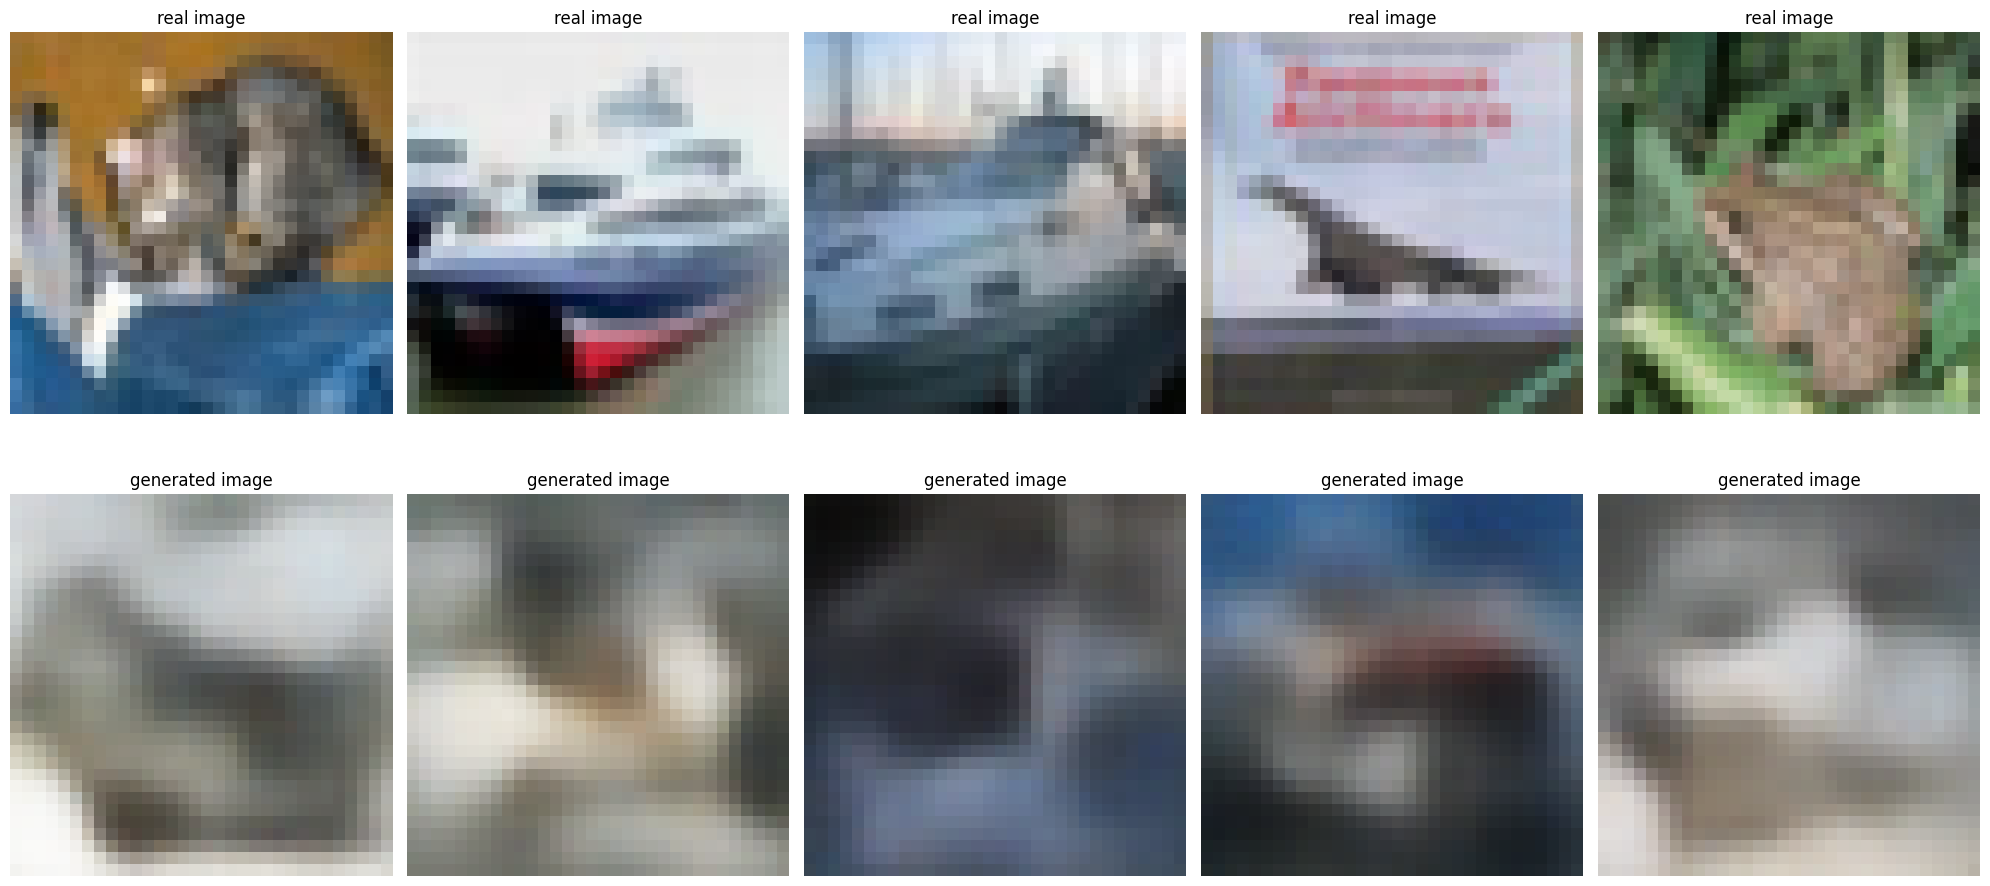

In [24]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
    plt.figure(figsize=(20,10))

    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, i + 1)
        plt.imshow(real_images[i])
        plt.title('real image')
        plt.axis('off')

        plt.subplot(2, num_images_to_generate, i + 1 + num_images_to_generate)
        plt.imshow(generated_images[i])
        plt.title('generated image')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_real_and_generated_images(x_test, generated_images, 5)

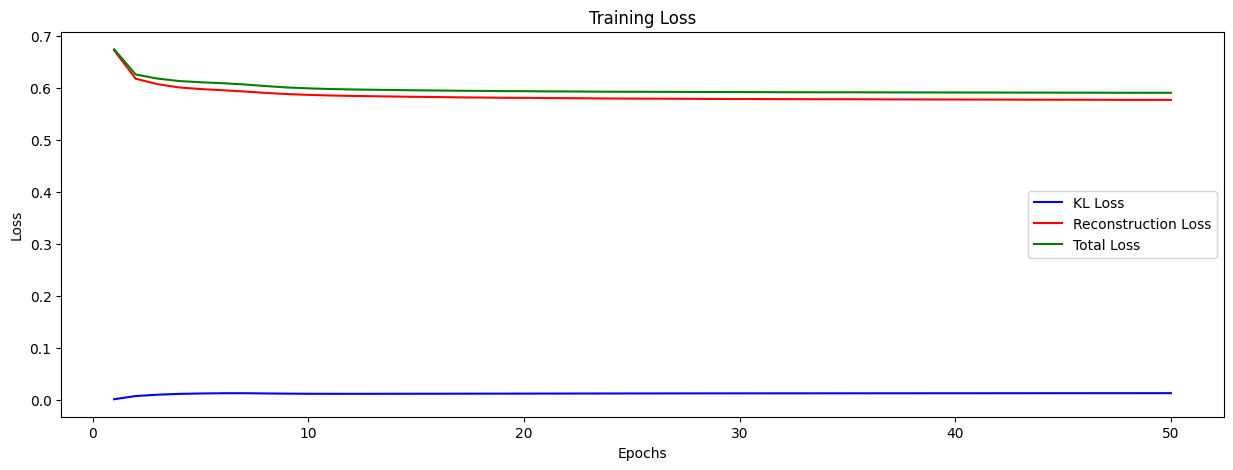

In [26]:
kl_loss = history.history["kl_loss"]
reconstruction_loss = history.history["reconstruction_loss"]
total_loss = history.history["loss"]

epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(15, 5))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
